# CSII 2025 Exercise 9: Internal Model Control & $H_{\infty}$ Control
© 2025 ETH Zurich, Aya Abrini, Livia Fischer, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

# Setup

In [1]:
# Install the required python library with pip
%pip install --upgrade cs2solutions
%pip install control==0.10.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import numpy as np
import control as ct
import matplotlib.pyplot as plt
from scipy import signal as signal
import scipy.linalg as la
from cs2solutions import Qparam

# Exercise 1: Modern Control Synthesis

In this task, you will learn how you can use the `control` library to set up your plants for synthesizing a controller. To express performance and stability constraints, you will create frequency weights and compute the augmented generalized plant that can be further used with various methods to synthesize a controller.

## Plant Definition

The plant used in this task models the linearized behavior of a simple inverted pendulum and is given as
$$P(s) = \frac{1}{s^2+0.1s-9.81}.$$

Note that this plant is unstable, and we will need to use a controller.

Initially, we define our controller $C(s)$ as a placeholder. In this state it does not manipulate the signal. It is written as: 
$$C(s) = 1.$$

In [3]:
# Defining the plant transfer function
P_s = ct.TransferFunction([1], [1, 0.1, -9.81], input='u', output='y', name='P(s)')

# Defining the placeholder controller transfer function
C_s = ct.TransferFunction([1], [1], input='e', output='u', name='C(s)')

print("Plant transfer function:")
display(P_s)
print("\nController transfer function:")
display(C_s)

Plant transfer function:


TransferFunction(array([1]), array([ 1.  ,  0.1 , -9.81]))


Controller transfer function:


TransferFunction(array([1]), array([1]))

We can easily check stability with `ct.poles` and see that the plant is unstable, having a pole with a positive real part.

In [4]:
ct.poles(P_s)

array([-3.18249102+0.j,  3.08249102+0.j])

Before we synthesize a controller to stabilize the plant, we specify the performance criteria using frequency weights. The next step will address the design of these weights.

## Exercise 1.1: Frequency Weights

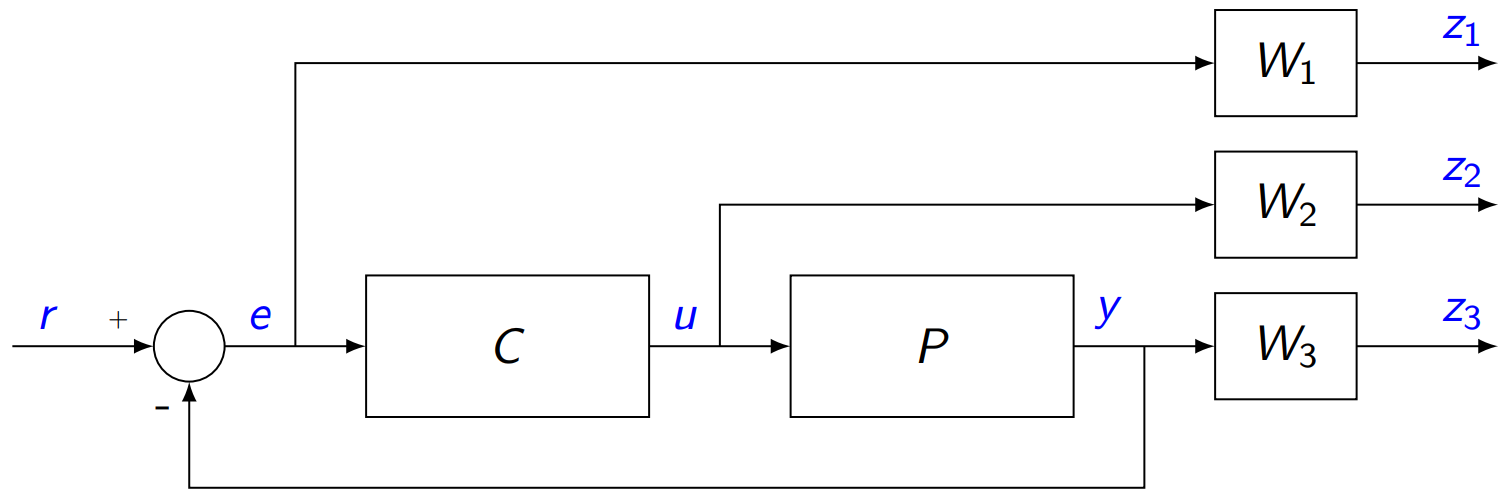


We want to create the two weights $W_1(s)$ and $W_3(s)$ to ensure reference tracking and noise attenuation. For now, we will ignore the weight $W_2(s)$ to keep the design more manageable.

Remember how we defined $W_1(s)$ and $W_3(s)$ in the lecture:
- $||W_1(s)S(s)|| << 1$ or $\sigma_{min}[L(s)] >> |W_1(s)|$
- $||W_3(s)T(s)|| <<$ 1 or $\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|}$

Therefore, we want $W_1(s)$ to have very large magnitudes at low frequencies, and $W_3(s)$ to have large magnitudes at high frequencies.

We start by implementing functions that create our frequency weights using the definitions from Lecture 9:
$$ W_1(s) = \frac{M}{Ms/\omega_1 + 1} \quad \text{and} \quad W_3(s) = \frac{Ms}{s + M\omega_3}.

The following code snippet defines functions that create the frequency weights. The weight parameters $M$, $w_1$ and $w_2$ are necessary inputs. The function outputs the transfer function of the frequency weight. The behaviour of the created transfer functions is further specified in the comment block.

In [5]:
# Function definition for frequency weight w1
def makeweight_1(M : float, w1 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - magnitude M >> 1 at low frequencies,
    - rolls off to zero at high frequencies,
    - and has magnitude 1 at the frequency s=j*w1.
    """
    return ct.TransferFunction([M], [M/w1, 1], name='W_1')

# Function definition for frequency weight w2
def makeweight_3(M: float, w3 : float) -> ct.TransferFunction:
    """
    Creates a frequency weight transfer function that has:
    - zero DC gain,
    - approaches M >> 1 at high frequencies,
    - and has magnitude 1 at the frequency s=j*w3.
    """
    return ct.TransferFunction([M, 0], [1, M*w3], name='W_3')

## Exercise 1.2: Specifying weight regions

Now define the two weights such that:

- $W_1(s)$ has a magnitude of 100 at low frequencies, rolls off to zero at high frequencies, and has a magnitude of 1 at a frequency of $\omega_1 = 0.1 \text{rad/s}$,
- $W_3(s)$ approaches a magnitude of 100 at high frequencies, has a magnitude of 1 at a frequency of  $\omega_3 = 10\text{rad/s}$, and has a zero DC gain.

In [6]:
# Calls the functions as defined in Exercise 1.1
W_1 = Qparam.sol_makeweight_1(100, 0.1)
W_3 = Qparam.sol_makeweight_3(100, 10)

To further assess the behaviour of the frequency weights, we can look at the singular value plots of these frequency weights and compare them to the open-loop transfer function $L(s)$. 

Since we want 
$\sigma_{min}[L(s)] >> |W_1(s)|$
and
$\sigma_{max}[L(s)] << \frac{1}{|W_3(s)|},$
we will invert $W_3(s)$ and find $L(s)$.


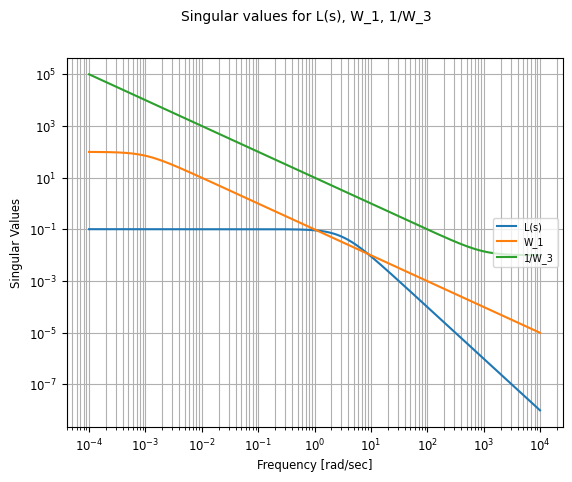

In [7]:
# Find the open loop transfer function
L_s = P_s * C_s
L_s.name = 'L(s)'

# Find the transfer function of the inverted W3
W_3_inverted = 1 / W_3
W_3_inverted.name = '1/W_3'

# Plotting the singular values of P, W1 and W3
_ = ct.singular_values_plot([L_s, W_1, W_3_inverted])

## Exercise 1.3: Assembly of the generalized plant

We want the open-loop transfer function $L(s)$ to lie between the upper and lower bounds given by $W_1(s)$ and $W_3(s)$ respectively. Note that we are dealing with a SISO system and therefore get only one singular value, implying $\sigma_{min}[L(s)] = \sigma_{max}[L(s)]$.

This loop shaping problem boils down to finding a controller $C(s)$ that places $L(s)$ between our bounds $W_1(s)$ and $W_3(s)$. We want to find the generalized plant
$$ G(s) = \begin{bmatrix} G_{zw}(s) & G_{zu}(s) \\ G_{yw}(s) & G_{yu}(s) \end{bmatrix},$$

which we can then use in an optimization problem to synthesize our controller $C(s)$.

One could derive each transfer function by hand and would find that
$$ G(s) = \begin{bmatrix} W_1(s) & -W_1(s)P(s) \\ 0 & W_3(s)P(s) \end{bmatrix},$$

or we can use the function `ct.augw(g, w1, w2, w3)` from the `control` library.

In [8]:
# Finding the generalized plant
G_s = ct.augw(P_s, w1=W_1, w2=None, w3=W_3)

display(G_s)

StateSpace(array([[-1.00e-03,  0.00e+00,  0.00e+00, -1.00e+00],
       [ 0.00e+00, -1.00e+03,  0.00e+00,  1.00e+00],
       [ 0.00e+00,  0.00e+00, -1.00e-01,  9.81e+00],
       [ 0.00e+00,  0.00e+00,  1.00e+00,  0.00e+00]]), array([[1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.]]), array([[ 1.e-01,  0.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e+05,  0.e+00,  1.e+02],
       [ 0.e+00,  0.e+00,  0.e+00, -1.e+00]]), array([[0., 0.],
       [0., 0.],
       [1., 0.]]))

Now we can use, for example, $H_2$ optimal control to synthesize our controller.

# Exercise 2: $H_{\infty}$ Control

The function we used before:

In [9]:
def systemInfnorm(system: ct.TransferFunction) -> float:
    """
    Returns an approximation of the infinity norm of the system

    Parameters:
    - ``system`` (ct.TransferFunction): The system to compute the infinity norm of

    Returns:
    - float: The infinity norm of the system
    """
    # Create a range of frequencies to analyze over
    omega = np.linspace(-4, 4, 1000)
    H = system(omega * 1j)

    # Consider the MIMO case
    if system.ninputs > 1 or system.noutputs > 1:
        # Calculate singular values
        singular_values = [np.linalg.svd(H[..., i])[1] for i in range(len(omega))]
    # Consider the SISO case
    else:
        singular_values = [np.absolute(H[..., i]) for i in range(len(omega))]

    # Return the highest singular value
    return np.vstack(singular_values).max()

------

## Exercise 2a:

As a recap from the last two weeks we will first calculate the $H_{\infty}$ norm via the state-space representation. The solution via the transfer function as introduced last week is given to check your own implementation.

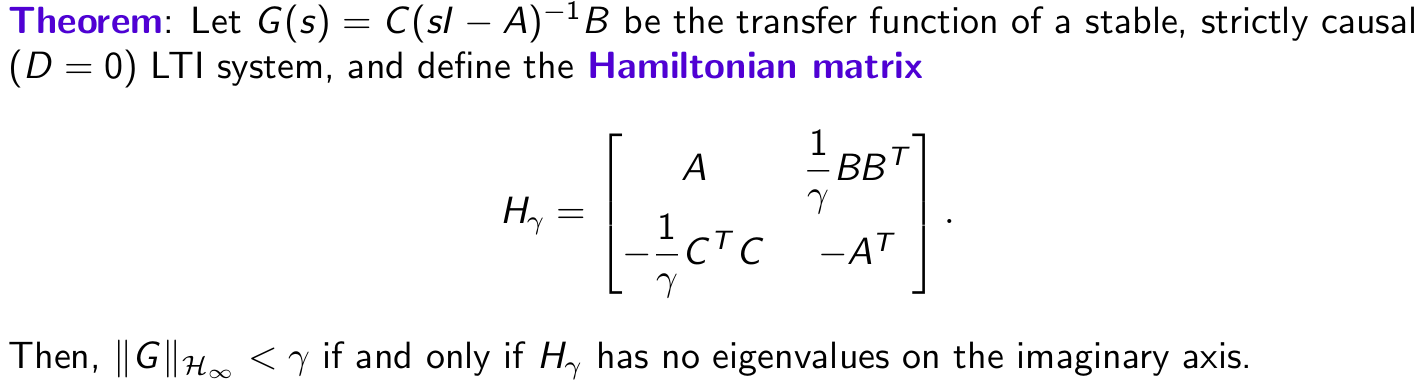

In [10]:
def H_inf_norm_state_space(A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray) -> float:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """

    gamma, step, precision = 1, 1, 1
    
    while precision > 1e-7:
        # Calculate the Hamiltonian matrix
        H = np.block([[A, 1/gamma*B@B.T], [-1/gamma*C.T@C, -A.T]])

        # Check if the eigenvalues are on the imaginary axis, then update gamma
        if any(np.isclose(np.linalg.eigvals(H).real, 0)):
            prev_gamma = gamma
            gamma = gamma + step
        else:
            prev_gamma = gamma
            gamma = gamma - step
        
        precision = abs(gamma - prev_gamma)
        step /= 2
        if gamma == 0:
            gamma = 1e-7
    
    return gamma

Below, you can verify that the _state-space_ and _transfer function_ implementations of the $H_{\infty}$ norm are equivalent.

In [13]:
# Define the state space matrices. Feel free to change these to test the function. It also works for MIMO systems.
A = np.array([[0, 1], [-2, -1]])
B = np.array([[0], [1]])
C = np.array([[2, 1]])
D = np.array([[0]])

# Calculate the infinity norms using the method introduced last week
tf = ct.ss2tf(A, B, C, D)
tf_norm = systemInfnorm(tf)

# Calculate the infinity norm using the state space method
ss_norm = H_inf_norm_state_space(A, B, C, D)

# Print the results
print(f"Transfer function infinity norm: {round(tf_norm,3)}")
print(f"State space infinity norm: {round(ss_norm,3)}")
if np.isclose(tf_norm, ss_norm, rtol=1e-2):
    print("The infinity norms match!")
else:
    print("The infinity norms do not match!")

Transfer function infinity norm: 1.785
State space infinity norm: 1.785
The infinity norms match!


------

## Exercise 2b:
You are working as a controls engineer at Autobau AG. It is your job to design a laneholding assistant. Because the lanes are denoted by striped lines (akin to this -----), the input data is noisy. As your first assignment you are tasked with coming up with an **optimal observer gain $L$** for your system, which looks as following.

$\dot{x}(t)=Ax(t)+B_ww(t)+B_uu(t) $

$z(t)=C_zx(t)+D_{zw}w(t)+D_{zu}(t) $

$y(t)=C_yx(t)+D_{yw}w(t)+D_{yu}u(t) $

Furthermore you can assume all initial conditions to be zero and also that $B_u = I$. You find the actual matrices below, but feel free to change them and test your own matrices.

In [14]:
A=np.array([[-10, 12, -1], [-1, 1.25, -2], [1, 0, -5]])

B_w=np.array([[0, 1, -4], [-1, 0, 2], [0, -1, 1]])
B_u=np.eye(3)

C_z=np.array([[1, 0, -1], [1, 0, 8], [0, 6, 1]])
C_y=np.eye(3)

D_zw=np.zeros((3,3))
D_zu=np.array([[-1, 0, -1], [2, 1, -3], [1, 10, 3]])
D_yw=np.array([[1, 0, 3], [6, 1, -0.5], [-1, 0, 1]])
D_yu=np.zeros((3,3))

You recall from your Control Systems II lecture that the optimal observer gain L is defined as:

$L = -(YC_y + B_w D_{yw}')R_{ww}^{-1}$

... where $Y_L$ is determined using a modified continous _algebraic riccati equation_:

$(A - B_wD_{yw}'R_{ww}^{-1}C_y)'Y + Y(A - B_wD_{yw}'R_{ww}^{-1}C_y) - YC_yR_{ww}^{-1}C_y'Y + B_w(I - D_{yw}'R_{ww}^{-1}D_{yw})B_w'=0$

_(Formulas and derivations found "Lecture 10: Modern Control Synthesis: $H_2, H_{\infty}, \mu$-synthesis)", slides 10-13_


We use the scipy.linalg function [``la.solve_continous_are``](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html) to have a short and easy solution.

In [15]:
def solve_riccati_equation(A: np.ndarray, B_w: np.ndarray, C_y: np.ndarray, R_ww: np.ndarray, D_yw: np.ndarray) -> np.ndarray:
    """
    Returns the solution to the continuous algebraic Riccati equation

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B_w`` (np.ndarray): The disturbance input matrix of the system
    - ``C_y`` (np.ndarray): The output matrix of the system
    - ``R_ww`` (np.ndarray): The disturbance covariance matrix
    - ``D_yw`` (np.ndarray): The feedthrough matrix from the disturbance to the output
    - ``Q`` (np.ndarray): The state cost matrix

    Returns:
    - np.ndarray: The solution to the continuous algebraic Riccati equation
    """
    a = (A - B_w@D_yw.T@np.linalg.inv(R_ww)@C_y).T
    b = C_y
    q = B_w@(np.eye(A.shape[0])-D_yw.T@np.linalg.inv(R_ww)@D_yw)@B_w.T
    r = np.linalg.inv(R_ww) 
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    Y = la.solve_continuous_are(a, b, q, r)
    return Y
    

In [16]:
def optimal_LQE(A: np.ndarray, B_w: np.ndarray, C_y: np.ndarray, D_yw: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    R_ww = D_yw @ D_yw.T
    Y = solve_riccati_equation(A, B_w, C_y, R_ww, D_yw)
    L = -(Y@C_y+B_w@D_yw.T)@np.linalg.inv(R_ww)
    
    return L

Finally, print the optimal observer gain using your function or the solution function:

In [17]:
L_optimal = optimal_LQE(A, B_w, C_y, D_yw)
# L_optimal = H_inf.sol_optimal_LQE(A, B_w, C_y, D_yw)
print("The optimal state feedback gain is:")
print(L_optimal)

The optimal state feedback gain is:
[[ 2.3750000e+00 -1.0000000e+00 -3.6250000e+00]
 [-2.5000000e-01 -8.8817842e-16 -1.2500000e+00]
 [-1.6250000e+00  1.0000000e+00  4.3750000e+00]]


## Exercise 2c: 
Similarly, the optimal controller gain can be solved using the LQR formulation presented in the slides:

$F = -(D_{zu}'D_{zu})^{-1}B_u'X_F$

... where $X_F$ is found using an _algebraic riccati equation_:

$A'X_F + X_FA+ X_FB_u(D_{zu}'D_{zu})^{-1}B_u'X_F + C_z'C_z=0$

_(Formulas and derivations found "Lecture 10: Modern Control Synthesis: $H_2, H_{\infty}, \mu$-synthesis)", slides 5-6_

In [18]:
def optimal_LQR(A: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, D_zu: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    a = A
    b = B_u
    q = C_z.T@C_z
    r = D_zu.T@D_zu
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    X_F = la.solve_continuous_are(a, b, q, r)
    F = -np.linalg.inv(r)@B_u.T@X_F
    
    return F

## Exercise 2d: 
Great, you managed to impress your project manager by coming up with an optimal observer for the LQG problem and controller for the LQR problem. 

Using the controller and observer gains $F$ and $L$ calculated earlier, he wants us to find an $H_2$-optimal controller as denoted by $K$.

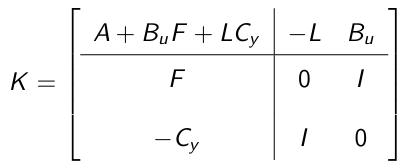

The linear algebra function [``np.block``](https://numpy.org/doc/stable/reference/generated/numpy.block.html) is used in this exercise which again enables a shorter solution.

In [24]:
def optimal_controller(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, D_zw: np.ndarray, D_zu: np.ndarray, D_yw: np.ndarray, D_yu: np.ndarray) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """
    # Find the optimal observer gain
    L = optimal_LQE(A, B_w, C_y, D_yw)
    
    # Find the optimal controller gain
    F = optimal_LQR(A, B_u, C_z, D_zu)
    
    A_K = A+B_u@F+L@C_y
    B_K = np.block([[-L, B_u]])
    C_K = np.block([[F], [-C_y]])
    D_K = np.block([
        [np.zeros((F.shape[1], L.shape[0])), np.ones((F.shape[1], B_u.shape[1]))], 
        [np.ones((C_y.shape[0], L.shape[0])), np.zeros((C_y.shape[0], B_u.shape[1]))]])
    
    K = np.block([[A_K, B_K], [C_K, D_K]])
    
    return K, A_K, B_K, C_K, D_K


K = optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
print("The optimal state feedback gain is:")
print(K[0])

The optimal state feedback gain is:
[[-8.19930410e+00  1.51746176e+01 -6.53153663e+00 -2.37500000e+00
   1.00000000e+00  3.62500000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.05757618e+00 -2.24417378e-01 -2.62070826e+00  2.50000000e-01
   8.88178420e-16  1.25000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [-1.01429344e+00  3.66123144e+00 -2.04259751e+00  1.62500000e+00
  -1.00000000e+00 -4.37500000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [-5.74304102e-01  4.17461758e+00 -1.90653663e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]
 [ 1.92423824e-01 -1.47441738e+00  6.29291736e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]
 [-3.89293440e-01  2.66123144e+00 -1.41759751e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]
 [-1.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000

------

## Exercise 3:

Now we will use the same system as before to find a suboptimal $H_{\infty}$ controller. For simplicity you can also assume **$\gamma = 0.5$**.

Solving for $X_{\infty}$ and $Y_{\infty}$ using two _continuous algebraic riccati equations_:

$X_{\infty}A + A^TX_{\infty} + X_{\infty}(\frac{1}{\gamma^2}B_wB_w^T - B_uB_u^T)X_{\infty}+C_z^TC_Z=0$

$AY_{\infty} + Y_{\infty}A^T + Y_{\infty}(\frac{1}{\gamma^2}C_zC_z^T - C_yC_y^T)Y_{\infty} + B_w^TB_w = 0$

The controller matrix is defined as follows:

$F_{\infty} = -B_u^TX_{\infty}$

$L_{\infty} = -Y_{\infty}C_y^T$

$Z_{\infty} = (I - \frac{1}{\gamma^2}X_{\infty}Y_{\infty})^{-1}$

$K = \begin{bmatrix}
A + \frac{1}{\gamma^2}B_wB_w^TX_{\infty} + B_wF_{\infty} + Z_{\infty}C_y & -Z_{\infty}L_{\infty} \\
F_{\infty} & 0 
\end{bmatrix}  $

More information on [Wikipedia](https://de.wikipedia.org/wiki/H-unendlich-Regelung).

In [ ]:
gamma = 0.5

In [ ]:
def find_X_inf(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    a = A
    b = np.eye(A.shape[1])
    q = C_z.T@C_z
    r = np.linalg.inv(1/gamma**2*B_w@B_w.T-B_u@B_u.T)
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    X = la.solve_continuous_are(a, b, q, r)
    return X
    

In [ ]:
def find_Y_inf(A: np.ndarray, B_w: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the infinity norm of the system defined by the state space matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``C`` (np.ndarray): The output matrix of the system
    - ``D`` (np.ndarray): The feedthrough matrix of the system

    Returns:
    - float: The infinity norm of the system
    """
    a = A
    b = np.eye(A.shape[1])
    q = B_w.T@B_w
    r = np.linalg.inv(1/gamma**2*C_z@C_z.T-C_y@C_y.T)
    
    # to combat floating point errors
    a = np.round(a, 10)
    b = np.round(b, 10)
    q = np.round(q, 10)
    r = np.round(r, 10)
    
    Y = la.solve_continuous_are(a, b, q, r)
    return Y

In [ ]:
def assemble_suboptimal_K(A: np.ndarray, B_w: np.ndarray, B_u: np.ndarray, C_z: np.ndarray, C_y: np.ndarray, D_zw: np.ndarray, D_zu: np.ndarray, D_yw: np.ndarray, D_yu: np.ndarray, gamma: float) -> np.ndarray:
    """
    Returns the optimal state feedback gain for the given system and cost matrices

    Parameters:
    - ``A`` (np.ndarray): The state matrix of the system
    - ``B`` (np.ndarray): The input matrix of the system
    - ``Q`` (np.ndarray): The state cost matrix
    - ``R`` (np.ndarray): The input cost matrix

    Returns:
    - np.ndarray: The optimal state feedback gain
    """    
    # Find the suboptimal X_inf and Y_inf
    X_inf = find_X_inf(A, B_w, B_u, C_z, gamma)
    Y_inf = find_Y_inf(A, B_w, C_z, C_y, gamma)
    
    # Find the suboptimal gains
    F_inf = -B_u.T@X_inf
    L_inf = -Y_inf@C_y.T
    
    # Define helper matrices
    Z_inf = np.linalg.inv(np.eye(A.shape[0])-1/gamma**2*X_inf@Y_inf)
    
    # Assemble the suboptimal controller
    A_K_suboptimal = A + 1/gamma**2 *B_w@B_w.T@X_inf + B_u@F_inf + Z_inf@C_y
    B_K_suboptimal = -Z_inf@L_inf
    C_K_suboptimal = F_inf
    D_K_suboptimal = np.zeros((F_inf.shape[0], L_inf.shape[1]))
    
    K = np.block([[A_K_suboptimal, B_K_suboptimal], [C_K_suboptimal, D_K_suboptimal]])
    
    return K, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal

Finally use the implementation to find the $H_{\infty}$ controller.

In [ ]:
gamma = 0.5 # Initial
K_suboptimal, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal = assemble_suboptimal_K(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu, gamma)
# K_suboptimal, A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal = H_inf.assemble_suboptimal_K(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu, gamma)
print("Suboptimal H_2 controller: \n", K_suboptimal)

# H_inf norm of the system
H_inf_norm = H_inf_norm_state_space(A_K_suboptimal, B_K_suboptimal, C_K_suboptimal, D_K_suboptimal)
print("H_inf norm of the system: ", H_inf_norm)


Suboptimal H_2 controller: 
 [[-1.06333561e+01 -3.28826022e+01 -3.17672979e+01  4.73952609e-02
   2.67416240e-02 -8.96339471e-02]
 [-9.85692535e-01  3.02266590e+01  6.57362361e+00  1.14356466e-03
   8.99991472e-02 -2.41311416e-02]
 [ 2.08821905e+00  1.12821827e+01  7.99217641e+00  9.78784736e-03
   5.27720557e-02 -1.00205631e-01]
 [-1.35992627e-01 -9.39016572e-03 -5.23222468e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-9.39016572e-03 -1.54957465e+00  1.99735921e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.23222468e-01  1.99735921e-01 -3.60255935e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
H_inf norm of the system:  0.884942452771759


In [ ]:
K, A_K, B_K, C_K, D_K = optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
# K, A_K, B_K, C_K, D_K = H_inf.sol_optimal_controller(A, B_w, B_u, C_z, C_y, D_zw, D_zu, D_yw, D_yu)
print("Optimal H_2 controller: \n", K)

print("In state space form:")
print("A_K:\n", A_K)
print("B_K:\n", B_K)
print("C_K:\n", C_K)
print("D_K:\n", D_K)

h_inf_norm = H_inf_norm_state_space(A_K, B_K, C_K, D_K)
print(f"The H_inf norm of the optimal controller is: {h_inf_norm}")

Optimal H_2 controller: 
 [[-8.19930410e+00  1.51746176e+01 -6.53153663e+00 -2.37500000e+00
   1.00000000e+00  3.62500000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [-1.05757618e+00 -2.24417378e-01 -2.62070826e+00  2.50000000e-01
   8.88178420e-16  1.25000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [-1.01429344e+00  3.66123144e+00 -2.04259751e+00  1.62500000e+00
  -1.00000000e+00 -4.37500000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [-5.74304102e-01  4.17461758e+00 -1.90653663e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]
 [ 1.92423824e-01 -1.47441738e+00  6.29291736e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]
 [-3.89293440e-01  2.66123144e+00 -1.41759751e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00]
 [-1.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00
  